#Training and Evaluation of Mask RCNN on toy dataset with 1 class

In [1]:
#Downloading matterport's implementation of Mask-RCNN
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.85 MiB | 41.66 MiB/s, done.
Resolving deltas: 100% (563/563), done.


In [ ]:
#Installing dependencies
#%cd /content/Mask_RCNN
#%cd ~/Mask_RCNN

#!pip install -q PyDrive
#!pip install -q -r requirements.txt
#!pip install -q -q -q tensorflow-gpu==1.15
#!sudo pip install -q -q -q --no-deps keras==2.2.5                  
#!python setup.py install
#!python3 setup.py install


In [3]:
#importing necessary libraries
from os import listdir
from xml.etree import ElementTree
import matplotlib.pyplot as plt
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
# evaluate the mask rcnn model on the kangaroo dataset
from os import listdir
from xml.etree import ElementTree
import numpy as np
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from numpy import expand_dims
from matplotlib.patches import Rectangle
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes


Using TensorFlow backend.


##Installing Kangaroo Dataset

In [5]:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 48.04 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [6]:
#reading sample annotation file
!cat kangaroo/annots/00001.xml

<annotation>
	<folder>Kangaroo</folder>
	<filename>00001.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/stock-photo-two-kids-in-the-zoo-feeding-kangaroo-296180786.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>450</width>
		<height>319</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>233</xmin>
			<ymin>89</ymin>
			<xmax>386</xmax>
			<ymax>262</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>105</ymin>
			<xmax>341</xmax>
			<ymax>253</ymax>
		</bndbox>
	</object>
</annotation>


In [7]:
#writing a function to parse xml file
# function to extract bounding boxes from an annotation file
def extract_boxes(filename):
	# load and parse the file
	tree = ElementTree.parse(filename)
	# get the root of the document
	root = tree.getroot()
	# extract each bounding box
	boxes = list()
	for box in root.findall('.//bndbox'):
		xmin = int(box.find('xmin').text)
		ymin = int(box.find('ymin').text)
		xmax = int(box.find('xmax').text)
		ymax = int(box.find('ymax').text)
		coors = [xmin, ymin, xmax, ymax]
		boxes.append(coors)
	# extract image dimensions
	width = int(root.find('.//size/width').text)
	height = int(root.find('.//size/height').text)
	return boxes, width, height

# extract details form annotation file
boxes, w, h = extract_boxes('kangaroo/annots/00001.xml')
# summarize extracted details
print(boxes, w, h)

[[233, 89, 386, 262], [134, 105, 341, 253]] 450 319


##Preparing dataset

In [8]:
# split into train and test set


# class that defines and loads the kangaroo dataset
class KangarooDataset(Dataset):
	# load the dataset definitions
	# class that defines and loads the kangaroo dataset

	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("dataset", 1, "kangaroo")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annots/'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('kangaroo'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']


In [9]:

# train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 131
Test: 32


In [10]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(339, 509, 3)
(339, 509, 1)


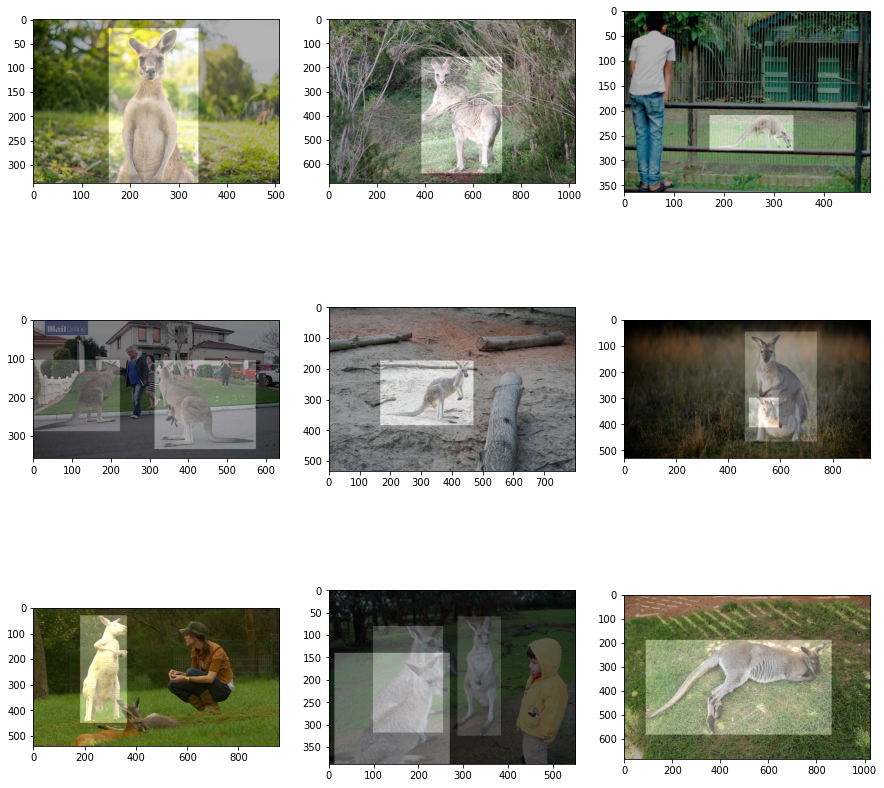

In [34]:
# plot few images
for i in range(9):
	# define subplot
	plt.rcParams['figure.figsize'] = [15, 15]
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	image = train_set.load_image(i)
	plt.imshow(image)
	# plot all masks
	mask, _ = train_set.load_mask(i)
	for j in range(mask.shape[2]):
		plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
# show the figure
plt.show()

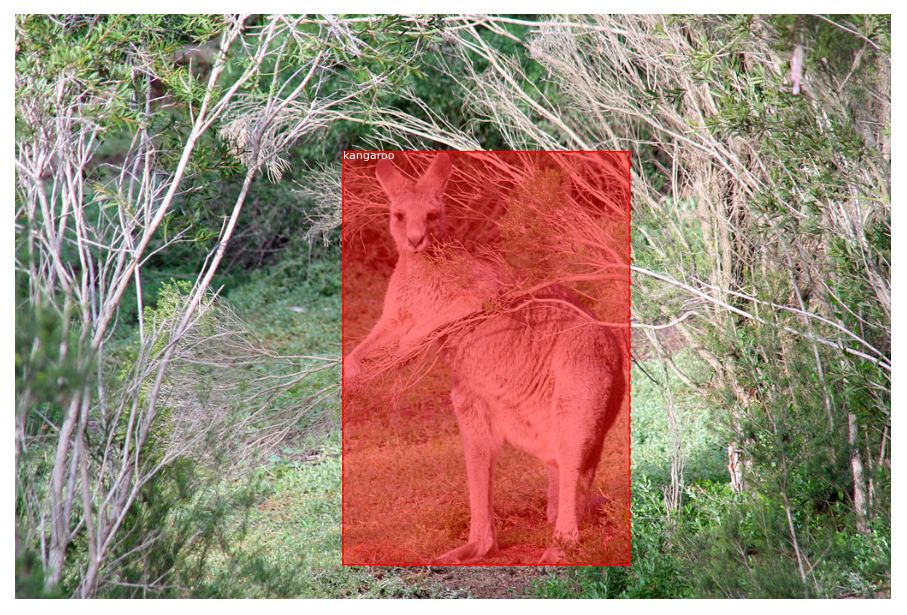

In [12]:
# display image with masks and bounding boxes
image_id = 1
# load the image
image = train_set.load_image(image_id)
# load the masks and the class ids
mask, class_ids = train_set.load_mask(image_id)
# extract bounding boxes from the masks
bbox = extract_bboxes(mask)
# display image with masks and bounding boxes
display_instances(image, bbox, mask, class_ids, train_set.class_names)

##Training

In [13]:
# define a configuration for the model
class KangarooConfig(Config):
	# Give the configuration a recognizable name
	NAME = "kangaroo_cfg"
  
	# Number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# Number of training steps per epoch
	STEPS_PER_EPOCH = 131
	DETECTION_MIN_CONFIDENCE=0.9
# prepare config
config = KangarooConfig()

In [14]:
# define the model
model = MaskRCNN(mode='training', model_dir='./', config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


Path to weights:
https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [15]:
model.load_weights('/content/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
# train weights (output layers or 'heads')
DEVICE = "/gpu:0" 
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')








Starting at epoch 0. LR=0.001

Checkpoint Path: ./kangaroo_cfg20200909T0516/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4   

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/usr/local/lib/python3.6/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'




Epoch 1/5
131/131 [==============================] - 201s 2s/step - loss: 0.9876 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.4088 - mrcnn_mask_loss: 0.3234 - val_loss: 0.7745 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.2479 - val_mrcnn_class_loss: 0.0245 - val_mrcnn_bbox_loss: 0.2464 - val_mrcnn_mask_loss: 0.2482

Epoch 2/5
131/131 [==============================] - 148s 1s/step - loss: 0.5870 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1518 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2317 - val_loss: 0.9455 - val_rpn_class_loss: 0.0111 - val_rpn_bbox_loss: 0.4179 - val_mrcnn_class_loss: 0.0424 - val_mrcnn_bbox_loss: 0.2375 - val_mrcnn_mask_loss: 0.2366
Epoch 3/5
131/131 [==============================] - 147s 1s/step - loss: 0.5017 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1338 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2132 - val_loss: 0.7621 - val_rpn_class_l

In [18]:
# define the prediction configuration
class PredictionConfig(Config):
	# define the name of the configuration
	NAME = "kangaroo_cfg"
	# number of classes (background + kangaroo)
	NUM_CLASSES = 1 + 1
	# simplify GPU config
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1
	DETECTION_MIN_CONFIDENCE = 0.9

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		# load image, bounding boxes and masks for the image id
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)
		# extract results for first sample
		r = yhat[0]
		# calculate statistics, including AP
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		# store
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return mAP

##Evaluation

In [20]:

test_set = KangarooDataset()
test_set.load_dataset('kangaroo', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('/content/Mask_RCNN/kangaroo_cfg20200909T0516/mask_rcnn_kangaroo_cfg_0005.h5', by_name=True)
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

Test: 32
Re-starting from epoch 5
Train mAP: 0.910
Test mAP: 0.953


mAP @ IoU=50:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]


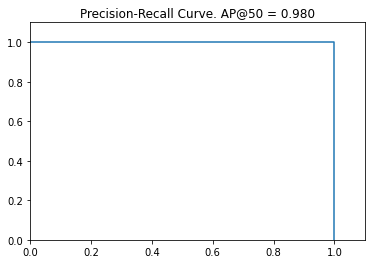

In [24]:
from mrcnn.visualize import plot_precision_recall
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(test_set, config, image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps = compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        AP =  AP
        APs.append(AP)
    return APs, precisions, recalls


image_ids = np.random.choice(test_set.image_ids, 25)
APs, precisions, recalls = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", APs)

AP = np.mean(APs)
plot_precision_recall(AP, precisions, recalls)
plt.show()

## Plotting actual vs predicted

In [31]:

def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
	# load image and mask
	plt.rcParams['figure.figsize'] = [15, 15]
	for i in range(n_images):
		# load the image and mask
		image = dataset.load_image(i)
		mask, _ = dataset.load_mask(i)
		# convert pixel values (e.g. center)
		scaled_image = mold_image(image, cfg)
		# convert image into one sample
		sample = expand_dims(scaled_image, 0)
		# make prediction
		yhat = model.detect(sample, verbose=0)[0]
		# define subplot
		plt.subplot(n_images, 2, i*2+1)
		# plot raw pixel data
		

		plt.imshow(image)
  
		plt.title('Actual')
		# plot masks
		for j in range(mask.shape[2]):
			plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
		# get the context for drawing boxes
		plt.subplot(n_images, 2, i*2+2)
		# plot raw pixel data
		plt.imshow(image)
		plt.title('Predicted')
		ax = plt.gca()
		# plot each box
		for box in yhat['rois']:
			# get coordinates
			y1, x1, y2, x2 = box
			# calculate width and height of the box
			width, height = x2 - x1, y2 - y1
			# create the shape
			rect = Rectangle((x1, y1), width, height, fill=False, color='red')
			# draw the box
			ax.add_patch(rect)
    #fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')

	# show the figure
	plt.show()
 

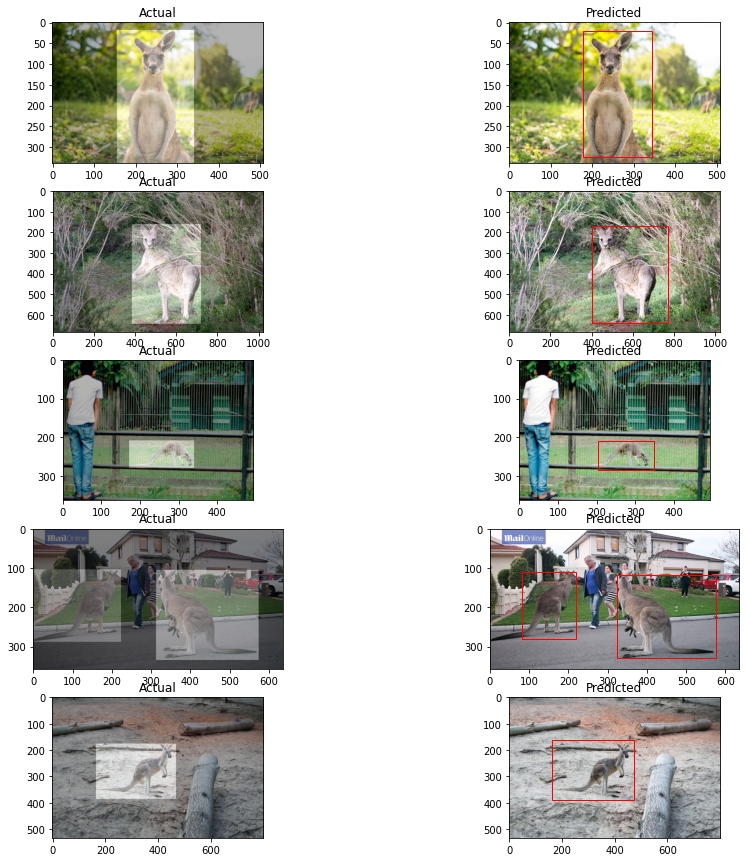

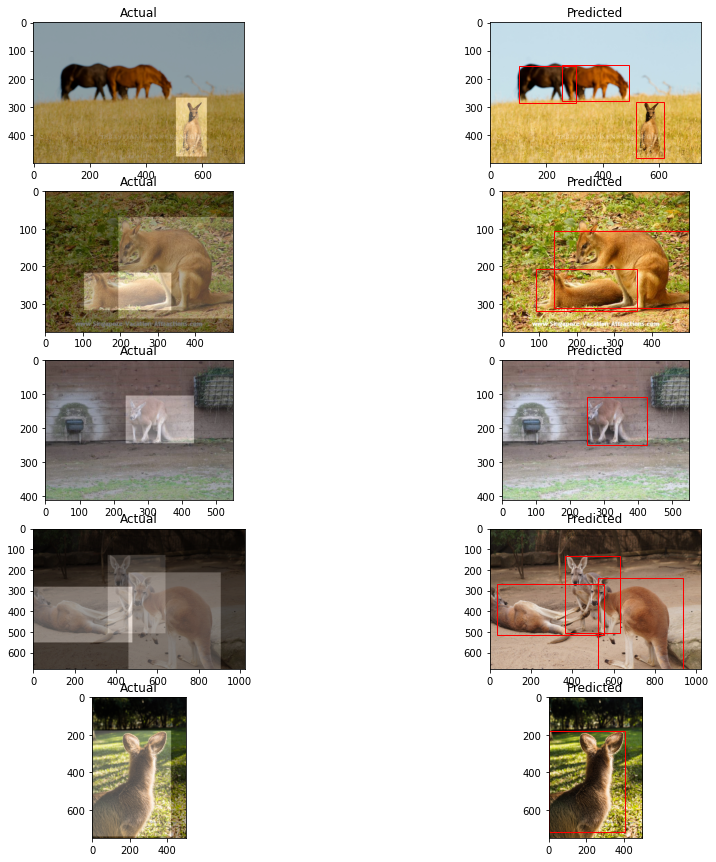

In [32]:
# plot predictions for train dataset
plot_actual_vs_predicted(train_set, model, cfg)
# plot predictions for test dataset
plot_actual_vs_predicted(test_set, model, cfg)

In [ ]:
#End of jupyter notebook